## Neural Nets and Backprop

Following along this video: https://www.youtube.com/watch?v=VMj-3S1tku0

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math 

Code for visualization:

In [2]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

We want to integrate without having to express everything in our neural network as a big expression to differenciate analytically so we'll use a representation of Value to do so iteratively:

In [18]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        # This is a set for efficiency
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self._backward = lambda: None
    
    def __repr__(self):
        return f"Value(data={str(self.data)})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
    
    def __radd__(self, other):
        return self + other

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out
    
    def __rmul__(self, other):
        return self * other
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "Power only supports int/float for now..."
        out = Value(self.data**other, (self, ), f"**{other}")

        def _backward():
            self.grad = other * self.data**(other-1) * out.grad

        out._backward = _backward

        return out
    
    def __truediv__(self, other):
        return self * other**-1
    
    def __sub__(self, other):
        return self + (-other)
    
    def __neg__(self):
        return self * -1

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad

        out._backward = _backward

        return out
    
    def backward(self):
        self.grad = 1.0

        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        build_topo(self)

        for node in reversed(topo):
            node._backward()
    
    def tanh(self):
        n = self.data
        t = (math.exp(2 * n) - 1) / (math.exp(2 * n) + 1)
        out = Value(t, _children=(self, ), _op='tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad

        out._backward = _backward
        return out

In [19]:
a = Value(-3.0, label='a')
b = Value(2.0, label='b')
c = Value(10.0, label='c')
e = a * b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'

In [20]:
L.backward()

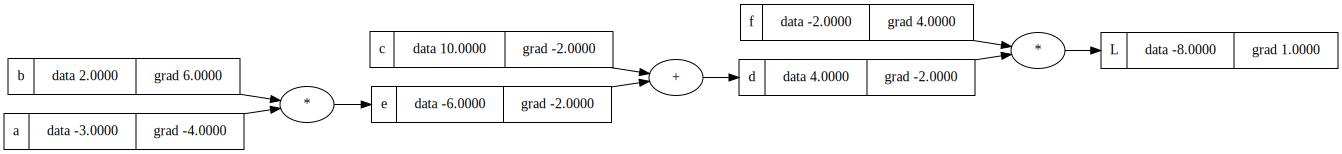

In [21]:
draw_dot(L)

In [91]:
import random


class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x):
        act = sum((wi * xi for wi, xi in zip(self.w,x)), self.b)
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]
    
class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for n in self.neurons for p in n.parameters()]
    
class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [92]:
x = [2.0, 3.0]
model = MLP(3, [4, 4, 1])
model(x)

Value(data=-0.3408454351996858)

Define our toy dataset

In [93]:
# Define a toy dataset
def toy_dataset(n=1000):
    X = [[random.uniform(-1, 1), random.uniform(-1, 1), random.uniform(-1, 1)] for _ in range(n)]
    # either 1 or 0 randomly
    y = [random.choice([-1.0, 1.0]) for _ in range(n)]
    return X, y

In [94]:
X, y = toy_dataset(10)
y

[1.0, -1.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 1.0]

Defining our loss:

In [87]:
loss = sum((yout - ygt)**2 for ygt, yout in zip(y, y_preds))
loss

Value(data=26.561972602058415)

TRAINING:

In [150]:
model = MLP(3, [4, 4, 1])

for i in range(1000):
    y_preds = [model(x) for x in X]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(y, y_preds))

    print(f"Loss at epoch {i} : {loss.data}")

    for p in model.parameters():
        p.grad = 0.0

    loss.backward()

    for p in model.parameters():
        p.data -= 0.01 * p.grad

Loss at epoch 0 : 21.796531790607006
Loss at epoch 1 : 17.898923046444175
Loss at epoch 2 : 12.613978926969205
Loss at epoch 3 : 9.770398981042561
Loss at epoch 4 : 9.20731117815905
Loss at epoch 5 : 9.028032642066146
Loss at epoch 6 : 8.92194966471972
Loss at epoch 7 : 8.838706696037923
Loss at epoch 8 : 8.766026550778513
Loss at epoch 9 : 8.699934276235673
Loss at epoch 10 : 8.638701369159836
Loss at epoch 11 : 8.58129922242116
Loss at epoch 12 : 8.526957557127758
Loss at epoch 13 : 8.475030517300706
Loss at epoch 14 : 8.42495249928762
Loss at epoch 15 : 8.376220114627264
Loss at epoch 16 : 8.328381758672371
Loss at epoch 17 : 8.28102972959603
Loss at epoch 18 : 8.233793740494004
Loss at epoch 19 : 8.186335696982939
Loss at epoch 20 : 8.138345837186936
Loss at epoch 21 : 8.08954036004804
Loss at epoch 22 : 8.03966066238714
Loss at epoch 23 : 7.988474293381556
Loss at epoch 24 : 7.935777708389187
Loss at epoch 25 : 7.881400843537527
Loss at epoch 26 : 7.825213417131694
Loss at epoch 2

In [153]:
y_preds

[Value(data=0.9671370142193432),
 Value(data=-0.9619210726520783),
 Value(data=0.9657869112685732),
 Value(data=-0.9714754083319519),
 Value(data=-0.9491769914135819),
 Value(data=-0.9939774861278045),
 Value(data=-0.9903757145177627),
 Value(data=-0.9616786991685817),
 Value(data=-0.9892099249545276),
 Value(data=0.9236249209959592)]

In [137]:
y_preds

[Value(data=1.0),
 Value(data=-0.9999999999976916),
 Value(data=1.0),
 Value(data=-1.0),
 Value(data=-1.0),
 Value(data=-1.0),
 Value(data=-1.0),
 Value(data=-1.0),
 Value(data=-1.0),
 Value(data=-1.0)]

In [126]:
loss.backward()

In [127]:
for p in model.parameters():
    p.data -= 0.01 * p.grad

In [128]:
loss = sum((yout - ygt)**2 for ygt, yout in zip(y, y_preds))
loss

Value(data=8.179001024089946)